In [10]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input


In [11]:
# =====================
# CONFIG
# =====================
IMG_SIZE = 224
BATCH_SIZE = 16

MODEL_PATH = r"C:\Users\adity\Downloads\Code\Knowledge Distillation\student_kd_mobilenetv3small.keras"
TEST_DIR = r"C:\Users\adity\Downloads\dataset_split_final\test"


In [12]:
# =====================
# TEST GENERATOR (IDENTIK TRAINING)
# =====================
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

NUM_CLASSES = test_gen.num_classes
CLASS_NAMES = list(test_gen.class_indices.keys())

print("Classes:", CLASS_NAMES)


Found 1000 images belonging to 10 classes.
Classes: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


In [13]:
student = tf.keras.models.load_model(
    MODEL_PATH,
    compile=False
)
print("✅ KD Student model loaded")

# Compile ONLY for evaluation
student.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)



✅ KD Student model loaded


In [14]:
print("\n🔍 Evaluating KD Student (FP32)...")

start = time.time()
loss_fp32, acc_fp32 = student.evaluate(test_gen, verbose=1)
total_time = time.time() - start

avg_infer = total_time / test_gen.samples
fps = 1 / avg_infer

print("\n✅ KD FP32 RESULTS")
print(f"Accuracy        : {acc_fp32*100:.2f}%")
print(f"Loss            : {loss_fp32:.4f}")
print(f"Avg infer/image : {avg_infer:.6f} sec")
print(f"FPS             : {fps:.2f}")



🔍 Evaluating KD Student (FP32)...


C:\Users\adity\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.9927 - loss: 0.2863

✅ KD FP32 RESULTS
Accuracy        : 99.20%
Loss            : 0.2888
Avg infer/image : 0.009435 sec
FPS             : 105.99


In [15]:
converter = tf.lite.TFLiteConverter.from_keras_model(student)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

tflite_fp16 = converter.convert()

with open("student_kd_fp16.tflite", "wb") as f:
    f.write(tflite_fp16)

print("✅ FP16 quantized model saved")


INFO:tensorflow:Assets written to: C:\Users\adity\AppData\Local\Temp\tmpg7czaqvn\assets


INFO:tensorflow:Assets written to: C:\Users\adity\AppData\Local\Temp\tmpg7czaqvn\assets


Saved artifact at 'C:\Users\adity\AppData\Local\Temp\tmpg7czaqvn'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  2334321917584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2334323061968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2334323064080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2334323062544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2334323062352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2334323063312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2334329333008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2334329331472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2334323063504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2334329333200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  23343

In [16]:
fp32_size = os.path.getsize(MODEL_PATH) / (1024 * 1024)
fp16_size = os.path.getsize("student_kd_fp16.tflite") / (1024 * 1024)

print("\n📦 MODEL SIZE")
print(f"FP32 : {fp32_size:.2f} MB")
print(f"FP16 : {fp16_size:.2f} MB")
print(f"Reduction : {(1 - fp16_size/fp32_size)*100:.2f}%")



📦 MODEL SIZE
FP32 : 4.40 MB
FP16 : 1.95 MB
Reduction : 55.69%


In [17]:
interpreter = tf.lite.Interpreter(
    model_path="student_kd_fp16.tflite"
)
interpreter.allocate_tensors()

input_details  = interpreter.get_input_details()
output_details = interpreter.get_output_details()


C:\Users\adity\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [18]:
y_true = []
y_pred = []

start = time.time()

test_gen.reset()
for i in range(len(test_gen)):
    x_batch, y_batch = next(test_gen)

    for j in range(x_batch.shape[0]):
        interpreter.set_tensor(
            input_details[0]["index"],
            x_batch[j:j+1].astype(np.float32)
        )
        interpreter.invoke()

        output = interpreter.get_tensor(output_details[0]["index"])

        y_true.append(np.argmax(y_batch[j]))
        y_pred.append(np.argmax(output))

total_time = time.time() - start
avg_infer = total_time / len(y_true)
fps = 1 / avg_infer


In [19]:
from sklearn.metrics import accuracy_score

acc_fp16 = accuracy_score(y_true, y_pred)

print("\n✅ FP16 TEST RESULTS")
print(f"Accuracy        : {acc_fp16*100:.2f}%")
print(f"Avg infer/image : {avg_infer:.6f} sec")
print(f"FPS             : {fps:.2f}")



✅ FP16 TEST RESULTS
Accuracy        : 99.20%
Avg infer/image : 0.003499 sec
FPS             : 285.78


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)


In [21]:
acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average="weighted")
rec  = recall_score(y_true, y_pred, average="weighted")
f1   = f1_score(y_true, y_pred, average="weighted")
cm = confusion_matrix(y_true, y_pred)



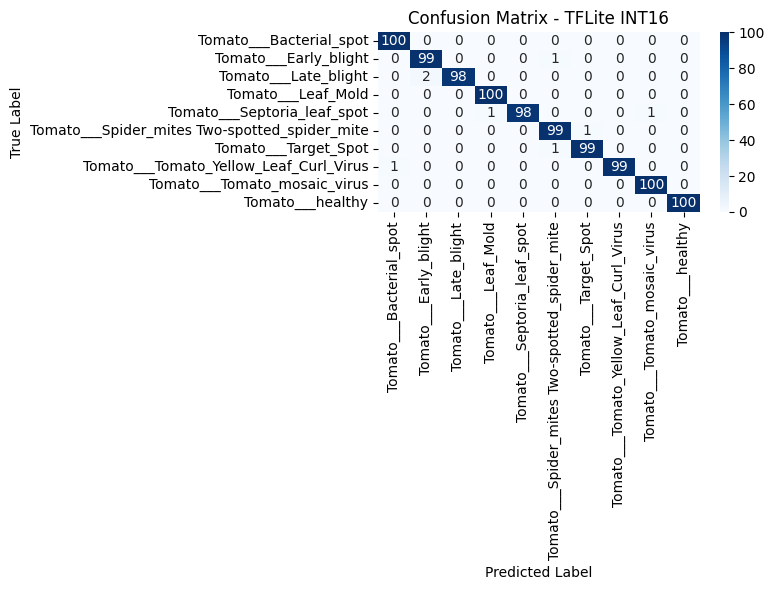

In [22]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - TFLite INT16")
plt.tight_layout()
plt.show()


In [23]:
print("\n📑 Classification Report:")
print(
    classification_report(
        y_true,
        y_pred,
        target_names=CLASS_NAMES,
        digits=4
    )
)



📑 Classification Report:
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot     0.9901    1.0000    0.9950       100
                        Tomato___Early_blight     0.9802    0.9900    0.9851       100
                         Tomato___Late_blight     1.0000    0.9800    0.9899       100
                           Tomato___Leaf_Mold     0.9901    1.0000    0.9950       100
                  Tomato___Septoria_leaf_spot     1.0000    0.9800    0.9899       100
Tomato___Spider_mites Two-spotted_spider_mite     0.9802    0.9900    0.9851       100
                         Tomato___Target_Spot     0.9900    0.9900    0.9900       100
       Tomato___Tomato_Yellow_Leaf_Curl_Virus     1.0000    0.9900    0.9950       100
                 Tomato___Tomato_mosaic_virus     0.9901    1.0000    0.9950       100
                             Tomato___healthy     1.0000    1.0000    1.0000       100

               

In [25]:
misclassified = []  # simpan (img_path, true_label, pred_label)


In [31]:
test_gen.reset()
idx = 0  # indeks global gambar

for i in range(len(test_gen)):
    x_batch, y_batch = next(test_gen)

    for j in range(x_batch.shape[0]):
        interpreter.set_tensor(
            input_details[0]["index"],
            x_batch[j:j+1].astype(np.float32)
        )
        interpreter.invoke()

        output = interpreter.get_tensor(output_details[0]["index"])

        true_idx = np.argmax(y_batch[j])
        pred_idx = np.argmax(output)

        y_true.append(true_idx)
        y_pred.append(pred_idx)

        # AMBIL PATH GAMBAR ASLI
        img_path = test_gen.filepaths[idx]

        # SIMPAN JIKA SALAH PREDIKSI
        if pred_idx != true_idx:
            misclassified.append(
                (img_path,
                 CLASS_NAMES[true_idx],
                 CLASS_NAMES[pred_idx])
            )

        idx += 1


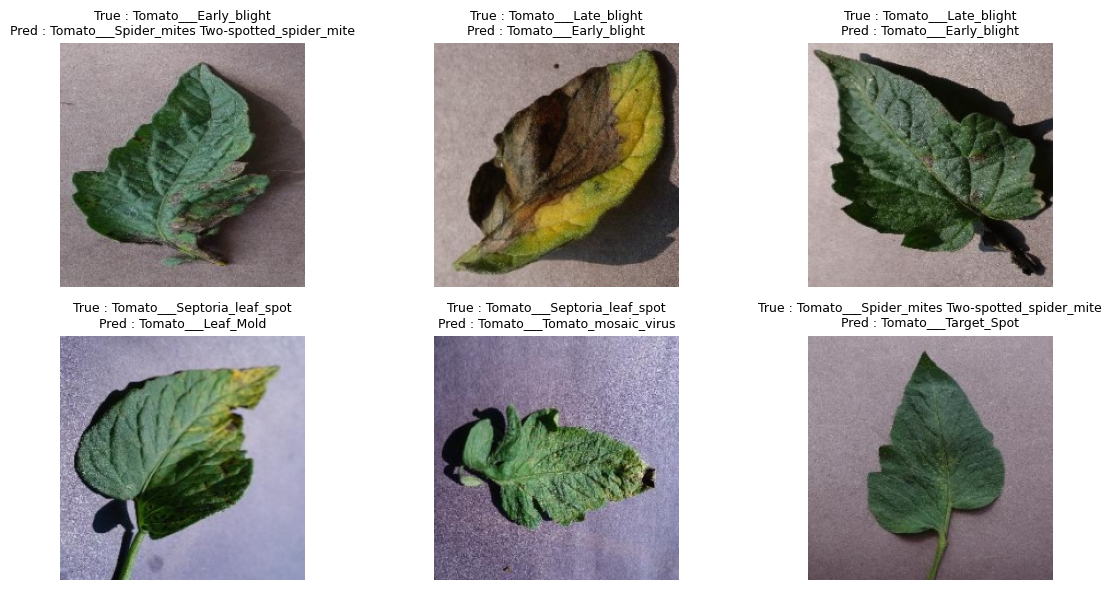

In [32]:
import matplotlib.pyplot as plt
from PIL import Image

N = 6  # jumlah gambar yang ingin ditampilkan

plt.figure(figsize=(12, 6))

for i, (img_path, true_label, pred_label) in enumerate(misclassified[:N]):
    img = Image.open(img_path)

    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(
        f"True : {true_label}\nPred : {pred_label}",
        fontsize=9
    )
    plt.axis("off")

plt.tight_layout()
plt.show()


In [34]:
print(student.class_names if hasattr(student, "class_names") else "No class_names")

print("External mapping:")
print(test_gen.class_indices)


No class_names
External mapping:
{'Tomato___Bacterial_spot': 0, 'Tomato___Early_blight': 1, 'Tomato___Late_blight': 2, 'Tomato___Leaf_Mold': 3, 'Tomato___Septoria_leaf_spot': 4, 'Tomato___Spider_mites Two-spotted_spider_mite': 5, 'Tomato___Target_Spot': 6, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 7, 'Tomato___Tomato_mosaic_virus': 8, 'Tomato___healthy': 9}
